# 參數設定 (使用訊號分解)

In [1]:
import os

labels = ['GroupCount']
model_type = 1 # 使用模型
predicteds = [2,4,6] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD
 
model_dir = 'DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: DecompEEMD/_Model/GroupCount_mt1_data246_batch14.x_scaler.pkl
y_scaler_file_name: DecompEEMD/_Model/GroupCount_mt1_data246_batch14.y_scaler.pkl
model_file_name: DecompEEMD/_Model/GroupCount_mt1_data246_batch14.model.keras
result_file_name: DecompEEMD/_Model/GroupCount_mt1_data246_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,"[2, 4, 6]",377381,954685,78374,23,1093,59,1164,1,0,0,10,0,0,1175
1,2023-04-03,"[2, 4, 6]",496147,1220042,83113,22,1414,80,1515,1,0,0,0,0,0,1516
2,2023-04-04,"[2, 4, 6]",435691,1054023,70665,25,1254,72,1351,0,0,0,0,0,0,1351
3,2023-04-05,"[2, 4, 6]",513216,1321385,123195,35,1493,78,1601,4,0,0,1,0,0,1606
4,2023-04-06,"[2, 4, 6]",1256282,3160850,212372,40,3717,78,3833,2,0,0,0,0,0,3835


# 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 395)
eIMFs shape : (8, 395)
residue shape : (395,)


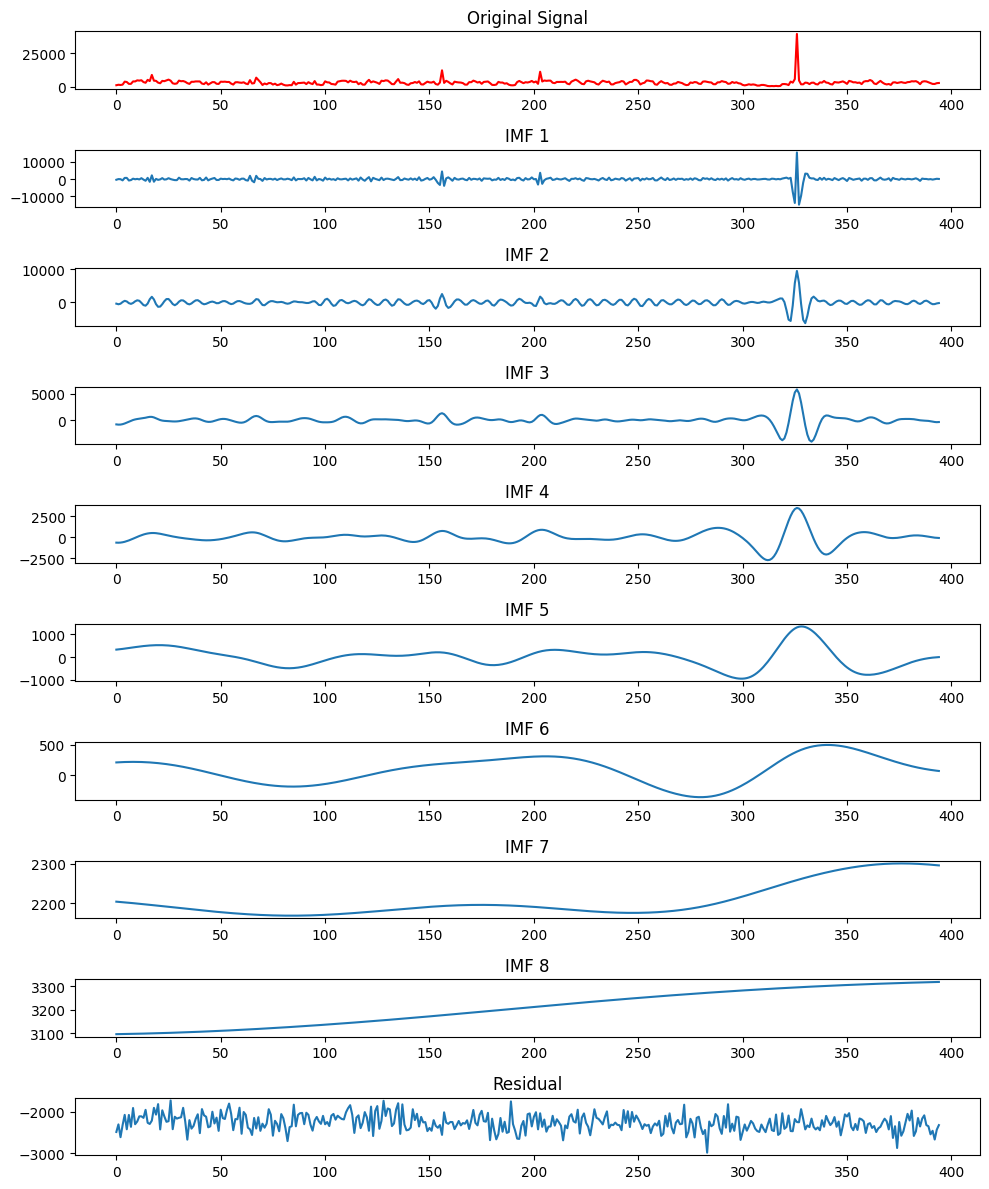

In [5]:
data_source = df_source[labels].values
eIMFs, residue, imfs = lstm.decomposition(data_source, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [6]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
----------------------------------------------------------------

# 最小最大正規化

In [7]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)

    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(395, 1)
y_norm.shape:(395, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [8]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [9]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (301, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [10]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：1
LSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [11]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [12]:
for i in range(len(models)):
    print_step(i + 1)   

    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt1_data246_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt1_data246_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt1_data246_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 DecompEEMD/_Model/GroupCount_mt1_data246_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
-----------------

# 預測

In [13]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (301, 1)
預測 train.shape : (301, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [14]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_

predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (301, 1)
actual_inverse_train.shape : (301, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)


# 預測資料加總

In [15]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(data_source, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (316, 1)
y_train.shape: (316, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (301, 1)
y_lstm_origin_train.shape : (301, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14, 1)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14, 1)
y_lstm_origin_val.shape : (24, 1)


In [16]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (301, 1)
actual_inverse_train_sum (301, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [17]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6327e-04 - mean_absolute_percentage_error: 3.8257

 2/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7254e-04 - mean_absolute_percentage_error: 3.8666

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5958e-04 - mean_absolute_percentage_error: 4.0013


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0193，MAPE:0.03927，MSE:0.00075，RMSE:0.0273，R square:-0.18597
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:584.76025，MAPE:2.44439，MSE:683888.40649，RMSE:826.97546，R square:-0.18597

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015 - mean_absolute_percentage_error: 4.6190

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mean_absolute_percentage_error: 4.6190


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02406，MAPE:0.04619，MSE:0.0015，RMSE:0.03868，R square:-1.27416
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:728.98959，MAPE:1.85772，MSE:1373204.67892，RMSE:1171.83816，R square:-1.27416

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9282e-04 - mean_absolute_percentage_error: 3.1005

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.9282e-04 - mean_absolute_percentage_error: 3.1005


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01524，MAPE:0.03101，MSE:0.00029，RMSE:0.01711，R square:-0.88717
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:461.6029，MAPE:7.23808，MSE:268706.38699，RMSE:518.36897，R square:-0.88717

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5513e-04 - mean_absolute_percentage_error: 3.4312

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7517e-04 - mean_absolute_percentage_error: 3.6210


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.01483，MAPE:0.03762，MSE:0.00039，RMSE:0.01972，R square:0.74753
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:233.8478，MAPE:1.79841，MSE:96687.62305，RMSE:310.94633，R square:0.74753

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mean_absolute_percentage_error: 13.3556

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0050 - mean_absolute_percentage_error: 13.3556


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.05489，MAPE:0.13356，MSE:0.00496，RMSE:0.07045，R square:-0.10041
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:865.52841，MAPE:2.18885，MSE:1233905.71613，RMSE:1110.81309，R square:-0.10041

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8030e-04 - mean_absolute_percentage_error: 2.6866

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8030e-04 - mean_absolute_percentage_error: 2.6866


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.01057，MAPE:0.02687，MSE:0.00018，RMSE:0.01343，R square:0.66926
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:166.67805，MAPE:0.62904，MSE:44828.42044，RMSE:211.72723，R square:0.66926

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3551e-05 - mean_absolute_percentage_error: 1.0654

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7211e-05 - mean_absolute_percentage_error: 1.3685


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0064，MAPE:0.01564，MSE:8e-05，RMSE:0.00891，R square:0.94074
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:63.7649，MAPE:0.75612，MSE:7882.64185，RMSE:88.78424，R square:0.94074

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_absolute_percentage_error: 1595161.6250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - mean_absolute_percentage_error: 1595161.6250


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.03167，MAPE:7183861983914.903，MSE:0.00194，RMSE:0.04405，R square:0.92459
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:315.44293，MAPE:0.53506，MSE:192585.70848，RMSE:438.84588，R square:0.92459

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8272e-05 - mean_absolute_percentage_error: 1.0430

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8272e-05 - mean_absolute_percentage_error: 1.0430


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00421，MAPE:0.01043，MSE:3e-05，RMSE:0.00532，R square:0.95401
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:41.97577，MAPE:0.33649，MSE:2805.50854，RMSE:52.96705，R square:0.95401

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8381e-05 - mean_absolute_percentage_error: 1.1354

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2911e-05 - mean_absolute_percentage_error: 1020.2782


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0051，MAPE:25242561648.28174，MSE:4e-05，RMSE:0.00614，R square:0.99584
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:32.04256，MAPE:1.02844，MSE:1483.45036，RMSE:38.51559，R square:0.99584

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0193e-04 - mean_absolute_percentage_error: 9.0347

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0193e-04 - mean_absolute_percentage_error: 9.0347


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02077，MAPE:0.09035，MSE:0.0006，RMSE:0.02453，R square:0.97805
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:130.3935，MAPE:0.20189，MSE:23722.63742，RMSE:154.02155，R square:0.97805

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2197e-05 - mean_absolute_percentage_error: 0.6906

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2197e-05 - mean_absolute_percentage_error: 0.6906


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00313，MAPE:0.00691，MSE:1e-05，RMSE:0.00349，R square:0.96486
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:19.67818，MAPE:0.41995，MSE:480.69439，RMSE:21.92474，R square:0.96486

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2193e-05 - mean_absolute_percentage_error: 0.4972

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5136e-05 - mean_absolute_percentage_error: 7303.1147


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00577，MAPE:118743867582.63048，MSE:5e-05，RMSE:0.00679，R square:0.99783
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:13.3475，MAPE:0.13646，MSE:246.06926，RMSE:15.68659，R square:0.99783

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_absolute_percentage_error: 9.5656

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - mean_absolute_percentage_error: 9.5656


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.04509，MAPE:0.09566，MSE:0.0027，RMSE:0.05192，R square:0.96606
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:104.21633，MAPE:0.28331，MSE:14402.15974，RMSE:120.009，R square:0.96606

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8634e-04 - mean_absolute_percentage_error: 7.0734

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8634e-04 - mean_absolute_percentage_error: 7.0734


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0193，MAPE:0.07073，MSE:0.00039，RMSE:0.01966，R square:0.94408
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:44.61595，MAPE:0.82378，MSE:2063.98604，RMSE:45.43111，R square:0.94408

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5036e-05 - mean_absolute_percentage_error: 0.6272

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2008e-05 - mean_absolute_percentage_error: 2347.6677


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00287，MAPE:38157252152.19486，MSE:1e-05，RMSE:0.00352，R square:0.99977
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:2.46419，MAPE:0.0398，MSE:9.14173，RMSE:3.02353，R square:0.99977

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2360e-04 - mean_absolute_percentage_error: 2.0865

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2360e-04 - mean_absolute_percentage_error: 2.0865


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.02038，MAPE:0.02087，MSE:0.00042，RMSE:0.02058，R square:0.21232
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:17.52074，MAPE:0.03678，MSE:313.10675，RMSE:17.69482，R square:0.21232

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.4177e-05 - mean_absolute_percentage_error: 1.1168

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4177e-05 - mean_absolute_percentage_error: 1.1168


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00637，MAPE:0.01117，MSE:4e-05，RMSE:0.00665，R square:0.98988
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:5.47489，MAPE:0.04732，MSE:32.654，RMSE:5.71437，R square:0.98988

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5983e-07 - mean_absolute_percentage_error: 0.3934

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3404e-06 - mean_absolute_percentage_error: 7009.9336


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.00146，MAPE:23822199267.3628，MSE:0.0，RMSE:0.00163，R square:0.99977
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.19273，MAPE:9e-05，MSE:0.04621，RMSE:0.21496，R square:0.99977

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6293e-04 - mean_absolute_percentage_error: 1.4195

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6293e-04 - mean_absolute_percentage_error: 1.4195


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01219，MAPE:0.0142，MSE:0.00016，RMSE:0.01276，R square:0.95399
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1.60669，MAPE:0.0007，MSE:2.83253，RMSE:1.68301，R square:0.95399

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 3.2327

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010 - mean_absolute_percentage_error: 3.2327


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.03196，MAPE:0.03233，MSE:0.00103，RMSE:0.03206，R square:-6.90037
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:4.21395，MAPE:0.00183，MSE:17.86959，RMSE:4.22724，R square:-6.90033

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0890e-06 - mean_absolute_percentage_error: 5.7894

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.7020e-07 - mean_absolute_percentage_error: 1.7495


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.0008，MAPE:0.00779，MSE:0.0，RMSE:0.00099，R square:0.99999
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.1788，MAPE:6e-05，MSE:0.0484，RMSE:0.22，R square:0.99999

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5318e-06 - mean_absolute_percentage_error: 0.1310

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5318e-06 - mean_absolute_percentage_error: 0.1310


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00122，MAPE:0.00131，MSE:0.0，RMSE:0.00124，R square:0.99028
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.27155，MAPE:8e-05，MSE:0.0761，RMSE:0.27587，R square:0.99028

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0688e-06 - mean_absolute_percentage_error: 0.2043

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0688e-06 - mean_absolute_percentage_error: 0.2043


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00202，MAPE:0.00204，MSE:0.0，RMSE:0.00202，R square:0.94236
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.44951，MAPE:0.00014，MSE:0.20217，RMSE:0.44963，R square:0.94237

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - mean_absolute_percentage_error: 23.5717

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0260 - mean_absolute_percentage_error: 540552.3750


--- 訓練值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:0.13028，MAPE:8793521927790.827，MSE:0.02623，RMSE:0.16195，R square:0.00795
--- 原始值比較 --- 
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:165.35092，MAPE:0.0738，MSE:42251.82885，RMSE:205.5525，R square:0.00795

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - mean_absolute_percentage_error: 21.1394

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146 - mean_absolute_percentage_error: 21.1394


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.10539，MAPE:0.21139，MSE:0.01461，RMSE:0.12088，R square:-0.30597
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:133.76593，MAPE:0.05789，MSE:23537.72975，RMSE:153.42011，R square:-0.30597

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0385 - mean_absolute_percentage_error: 57.0862

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0385 - mean_absolute_percentage_error: 57.0862


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.16008，MAPE:0.57086，MSE:0.0385，RMSE:0.19621，R square:-0.35972
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:203.18421，MAPE:0.08329，MSE:62020.16102，RMSE:249.03847，R square:-0.35972

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (301, 1), Predict shape: (301, 1)
MAE:661.86136，MAPE:0.22798，MSE:863492.8902，RMSE:929.24318，R square:0.53886

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:1001.08869，MAPE:0.37642，MSE:1549903.00876，RMSE:1244.95101，R square:-1.70596

------------------------------------------------------------------------
合併後 Test Evaluate
----------------------------------------------------------------

# 顯示預測圖表

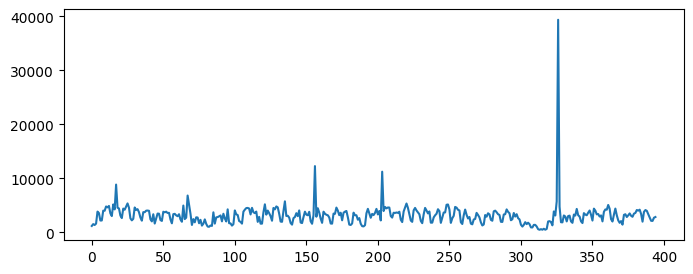

In [18]:
plt.figure(figsize=(8, 3))
plt.plot(data_source)
plt.show()

## 訓練集

原始資料 (316, 1)
[[466]
 [582]
 [480]]
原始資料2 (301, 1)
[[466]
 [582]
 [480]]
還原原始資料 (301, 1)
[[-2443.87072588]
 [-2466.37961933]]


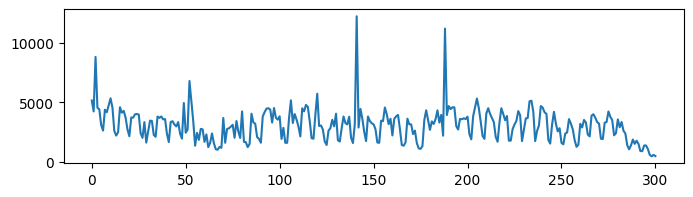

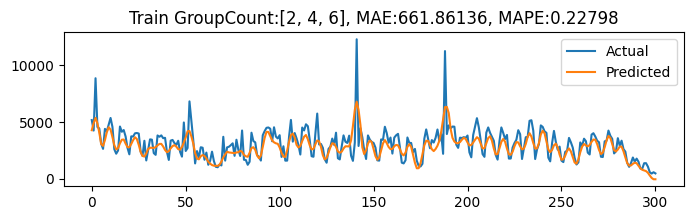

In [19]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39, 1)
[[4008]
 [3326]
 [3385]]
原始資料2 (24, 1)
[[4008]
 [3326]
 [3385]]
還原原始資料 (24, 1)
[[-2445.33232409]
 [-2293.03175617]]


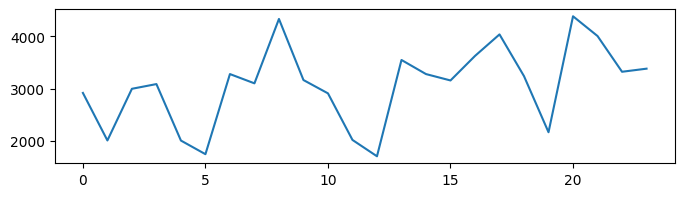

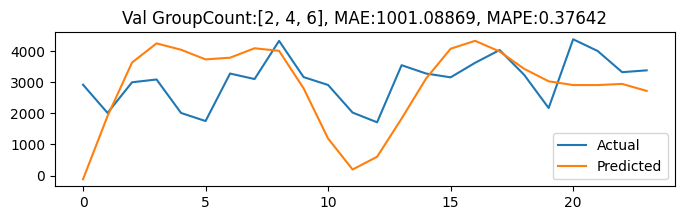

In [20]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40, 1)
[[2108]
 [2704]
 [2832]]
原始資料2 (25, 1)
[[2108]
 [2704]
 [2832]]
還原原始資料 (25, 1)
[[-2432.23440339]
 [-2321.50376215]]
Test GroupCount:[2, 4, 6], BatchSize:14, MAE:398.66113, MAPE:0.14122


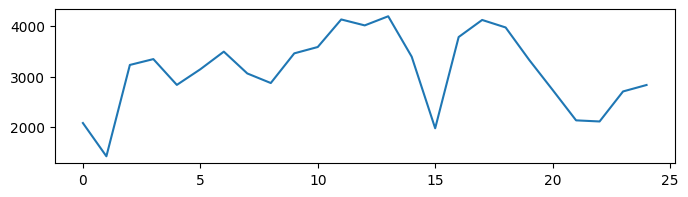

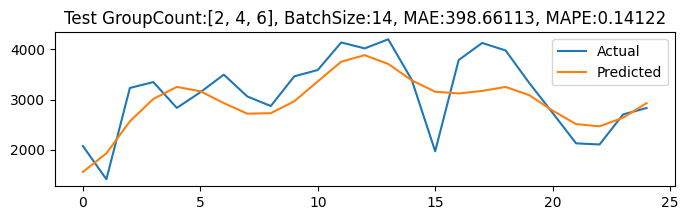

In [21]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [22]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'DecompEEMD', 'labels': ['GroupCount'], 'model_type': 1, 'predicteds': [2, 4, 6], 'batch_size': 14, 'train_mae': 661.86136, 'train_mape': 0.22798, 'test_mae': 398.66113, 'test_mape': 0.14122, 'kfold': None, 'imfs': 9}
儲存評估結果到 DecompEEMD/_Model/GroupCount_mt1_data246_batch14.result.json
